# Sea Rise Risk Prediction

## Overview

This is a demo script to illustrate the power of AGB Geospatial APIs. While retrieving and studying about AGB cover can be done in Geospatial APIs, it can also help us in understanding and determining the possible regions that are under the threat of rise in sea levels.

We use <i>Shuttle Radar Topography Mission (SRTM)</i> DEM to determine this usecase. SRTM is a Digital Elevation Model that emphasizes on its application advantages in various research fields including, but not limited to, geology, geomorphology, water resources and hydrology, glaciology, evaluation of natural hazards and vegetation surveys.

### Note

SRTM, JAXA, and GMTED are all digital elevation models (DEMs) that can be utilized for various applications. Each DEM has different error margins and resolutions. For this specific use case, we selected the SRTM DEM.

### Setup
Before starting, you have to install IBM EI Geospatial python SDK using `pip3 install -U ibmpairs` and the folium module and rasterio module, specifically needed for this sample using `pip3 install folium`, `pip3 install rasterio`.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [ ]:
!pip install ibmpairs
!pip install rasterio
!pip install folium

Let's start with some necessary imports

In [2]:
import os, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import query, client
import ibmpairs.client as client
import ibmpairs.query as query
import json
import rasterio
import configparser
from IPython.display import display as display_summary
from IPython import display
import folium
import branca.colormap as cm
from matplotlib import colors as colors

Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

In [3]:
config = configparser.RawConfigParser()
config.read("../../auth/secrets.ini")

EI_API_KEY    = config.get("EI", "api.api_key")
EI_TENANT_ID  = config.get("EI", "api.tenant_id") 
EI_ORG_ID     = config.get("EI", "api.org_id")  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    version   = 3
                                   )

2024-06-25 16:59:02 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-25 16:59:02 - paw - INFO - Legacy Environment is False
2024-06-25 16:59:02 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-25 16:59:04 - paw - INFO - Authentication success.
2024-06-25 16:59:04 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3



The following code submits a query that selects all pixels in the New York area that have elevations above sea level ("filter": {"operator": "GT", "value": "0"}). The query covers the entire time period from January 1, 2024 to January 1, 2024. And waits for it to finish, downloads the data to the download folder, loads the data to memory and displays it on screen. This could take a few minutes to complete as all the data is brought together.

Let's go ahead, define and submit a query.

In [4]:
# Sea level rise and tempest risks using a GSA Filter predicate in the query : https://www.climate.gov/news-features/understanding-climate/climate-change-global-sea-level
# Every location between 0m and 10m  is at risks for the next 50 years (high tides, sealevel rise, & storms). EPCCC said that  sea will rise by at least x meters up  to y meters depending of scenario by 2100

NY_Sea_rise_risk_query_object = query.submit_check_status_and_download ({
  "name" : "NY area at risk of sea rise level",
  "layers": [    
           { "type": "raster", 
              "id": "49506",  # SRTM DEM datalayer   30m resolution with error margin ...
              "temporal": {"intervals": [{"snapshot": "2024-01-01T00:00:00Z"}]}, "output": True,
              "filter": {"operator": "GT", "value": "0"}},   # Where elevation is higher than sea level (i.e. 0 ) 
          ],
  # the Area of interest
 "spatial": {"type": "square", "coordinates": [ 40.3725,-74.3498,  41.3396,-72.2332]},  # NY area
  # The dates 
 "temporal": {"intervals": [{"snapshot": "2024-01-01T00:00:00Z"}]}
}, client= EI_client_v3, verify=False)

2024-06-25 16:59:04 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-25 16:59:05 - paw - INFO - The query was successfully submitted with the id: 1719273600_41345873.
2024-06-25 16:59:06 - paw - INFO - The query 1719273600_41345873 has the status Queued.
2024-06-25 16:59:37 - paw - INFO - The query 1719273600_41345873 has the status Running.
2024-06-25 17:00:08 - paw - INFO - The query 1719273600_41345873 has the status Running.
2024-06-25 17:00:40 - paw - INFO - The query 1719273600_41345873 has the status Running.
2024-06-25 17:01:11 - paw - INFO - The query 1719273600_41345873 has the status Running.
2024-06-25 17:01:41 - paw - INFO - The query 1719273600_41345873 has the status Running.
2024-06-25 17:02:13 - paw - INFO - The query 1719273600_41345873 has the status Succeeded.
2024-06-25 17:02:13 - paw - INFO - The query 1719273600_41345873 was successful after checking the status.
2024-06-25 17:02:44 - paw - INFO - The query 1719273600_41345873 has the status

Let's define some utility functions to plot the downloaded raster tiff(s) and the summary file(s).

In [5]:
pd.set_option('display.max_colwidth', None)

def get_extent(f):
    with open(f, "r") as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent

def display_raster(raster_file_name, colorMap, title = None, Max=None, Min=None, myextent=None,savepng=False):
    if  raster_file_name.endswith(".tiff"):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent=get_extent(raster_file_name+".json")
            data = raster_file.read(1)
            fig=plt.figure(figsize = (20, 12))
            if Max is None:
                Max=data.max()
            if Min is None:
                Min = data.min()
            plt.imshow(data, cmap = colorMap, vmin = Min, vmax = Max,extent = myextent)
            if not title:
                title=os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()
            if savepng:
                plt.axis('off')
                fig.savefig(raster_file_name.replace(".tiff",".jpg"), bbox_inches='tight', pad_inches=0)            

Let's display the resulting raster tiff file(s) and the summary file(s) using the above methods.

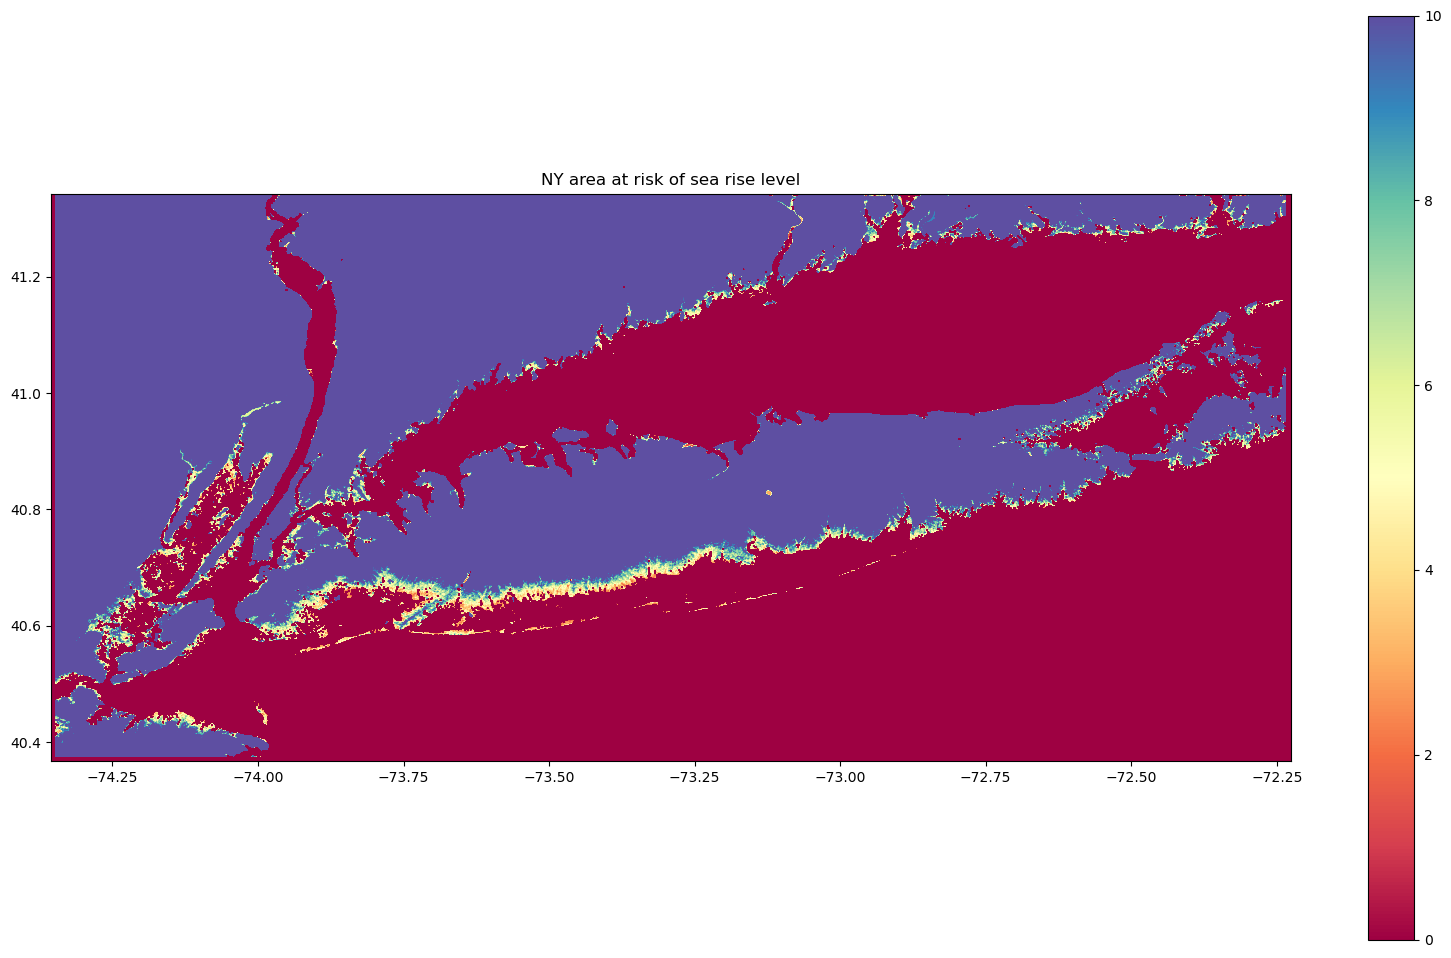

In [6]:
result_rasterfiles_list = NY_Sea_rise_risk_query_object.list_files()
for NY_risk_file in result_rasterfiles_list:
    display_raster(NY_risk_file, 'Spectral', title="NY area at risk of sea rise level", Min=0, Max=10)


As we can see in the above raster tiff file that's plotted, entire New York area is being displayed and there are a couple of colors in different parts of the raster tiff Red, Yellow and Blue which indicate high, moderate and low risk respectively. The above file indicates the degree of risk associated with the area being displayed. The values specifically range from 0 to 10, with 0 indicating  most risk as you are closer to the sea level, and 10 indicationg less risk as you are above or equal to 10 m  elevation.


Below is the code snippet to overlay the above tiff on a world map to get an interactive visual display, after which we display the corresponding screenshot for ease of rendering the notebook

In [ ]:
# For visualizing maps
Max_risk_elevation = 20

def create_fast_colormap_for_range(mycmmap_choice,vmin,vmax, empty_val):
    cm = mycmmap_choice.scale(vmin,vmax)   # cm.linear.Spectral_07.scale(0, 20)  # .to_step(1)
    cmArray = []
    for i in range(0,255, 1):
        if i> vmax or  i == empty_val:   # i>20 or i==0:
            cmArray.insert(i,(1, 0, 0, 0))
        else:
            cmArray.insert(i,colors.to_rgba(cm(i), 0.8))
    return cmArray

cmArray = create_fast_colormap_for_range(cm.linear.Spectral_07, 0,Max_risk_elevation, 0)

for NY_risk_file in result_rasterfiles_list:
    if NY_risk_file.endswith('.tiff'):
        with rasterio.open(NY_risk_file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds
            
            Map = folium.Map( max_bounds=True,
                    location=[(rb.bottom+rb.top)/2, (rb.left+rb.right)/2],   # [40.8768,-73.6195],
                    zoom_start=9,
                    min_lat=rb.bottom, # min_lat,
                    max_lat=rb.top,    # max_lat,
                    min_lon=rb.left,   # min_lon,
                    max_lon=rb.right   #max_lon
                    )
            Data = raster.read(1).astype(np.uint8)
            Data[Data >Max_risk_elevation] = 0   # set everything above 20 m  as  nodata and let be it 0

            folium.raster_layers.ImageOverlay(
                        image=Data,opacity=0.7,
                        colormap=lambda value: cmArray[value],
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(Map)
            Map.add_child(cm.linear.Spectral_07.scale(0,Max_risk_elevation))
Map

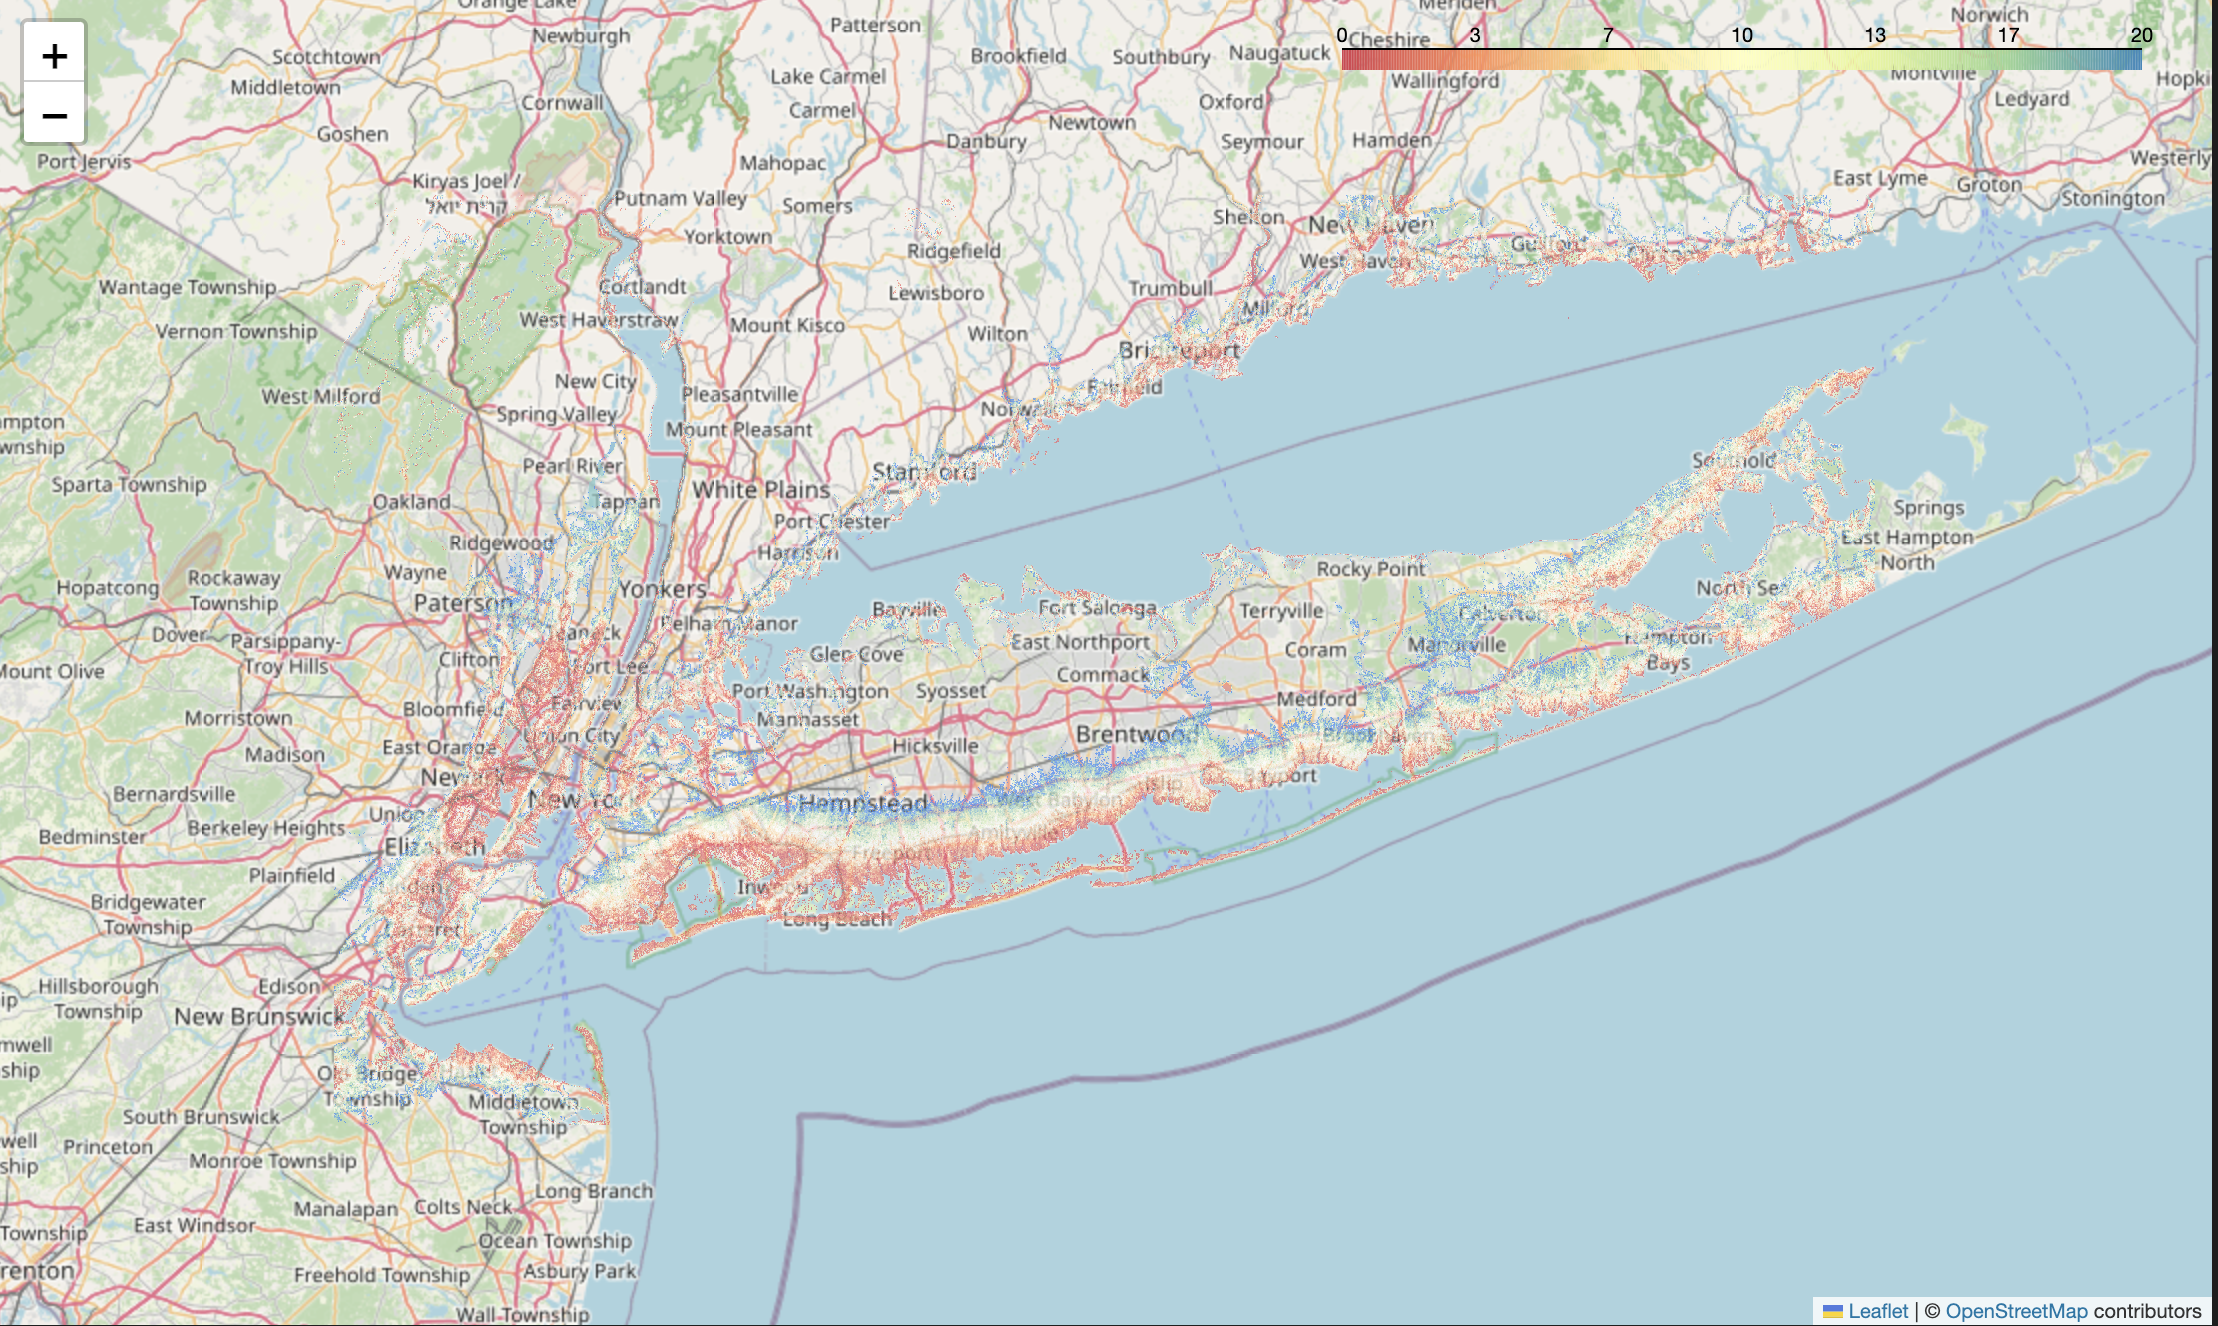

In [8]:
display.Image('sea_rise_risk_prediction.png')